# PACE L2 for AVUELO: 2/17/25 

In [6]:
# Load Modules
!pip install earthaccess
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import h5netcdf
from IPython.display import JSON
import geopandas as gpd
from shapely.geometry import Point, LineString
import re
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import pace_func

In [7]:
# Authentification
auth = earthaccess.Auth()
auth.login(strategy="interactive", persist=True)
print('Authenticated:' + str(auth.authenticated))

Enter your Earthdata Login username:  m11keluis
Enter your Earthdata password:  ········


Authenticated:True


In [8]:
# Search Criteria
doi = "2025-02-17"
tspan = (doi, doi)
N = 10
uN=10.5
S = 9.45
W =-84.951187
E= -84.653903
bbox=(W, S, E, N)
ubbox=(W,S,E,uN)

In [9]:
# Upload Cast Data
df = pd.read_csv('../data/cast_info.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_subset = df[df['timestamp'].dt.date == pd.to_datetime(doi).date()] 

## PACE: Level 2 - BGC

In [10]:
# Search for PACE Imagery
bgc_results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=ubbox,
)

# Pull from Cloud
paths = earthaccess.open(bgc_results)

AttributeError: 'NoneType' object has no attribute 'open'

In [123]:
# Format Dataset and Array
dataset = process_l2(paths[0])
array = log_chl(dataset["chlor_a"])

In [120]:
# Full Dataset
plot_bgc(dataset, array, sub_dataset, sub_array, df_subset)

## PACE L2: AOP 

In [15]:
# Search for PACE Imagery
aop_results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

# Pull from Cloud
aop_paths = earthaccess.open(aop_results)

AttributeError: 'NoneType' object has no attribute 'open'

In [89]:
# Pull Rrs
dataset = xr.open_dataset(aop_paths[0], group="geophysical_data")
rrs = dataset["Rrs"]

# Pull coordinate data
dataset = xr.open_dataset(aop_paths[0], group="navigation_data")
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = xr.merge((rrs, dataset.coords))

# Pull Wavelength data
wl_dataset = xr.open_dataset(aop_paths[0], group="sensor_band_parameters")
wl = wl_dataset['wavelength_3d'].values

# Formatting Data
match = re.search(r"(PACE_OCI\.[^/,]+\.nc)", aop_paths[0].details['name'])
if match:
    filename = match.group(1)

date = re.search(r"\d{8}", filename).group()

## Plot Spectra for Bounding Box

In [90]:
# Subset for bounding box
rrs_box = dataset["Rrs"].where(
    (
        (dataset["latitude"] > S)
        & (dataset["latitude"] < N)
        & (dataset["longitude"] > W)
        & (dataset["longitude"] < E)
    ),
    drop=True,
)

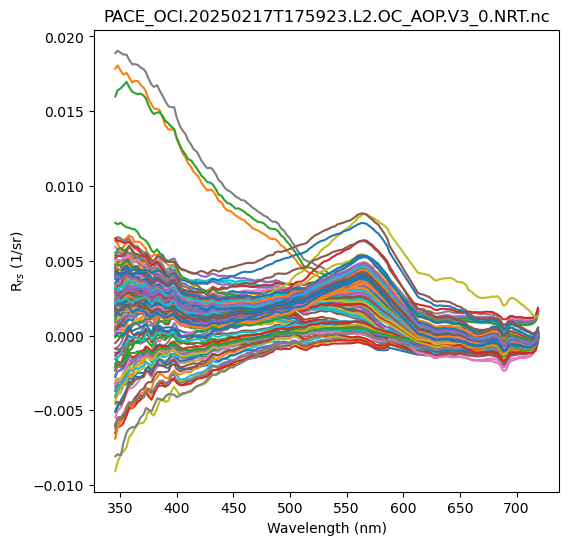

In [91]:
# All Pixels in Subset Region  
rrs_stack = rrs_box.stack(
    {"pixel": ["number_of_lines", "pixels_per_line"]}, create_index=False,
)

fig, ax = plt.subplots(figsize=(6, 6))  # Ensures a square figure
for pixel in rrs_stack['pixel'].values:  # Iterate over pixels
    ax.plot(wl, rrs_stack.sel(pixel=pixel), label=f"Pixel {pixel}")
    
ax.set_xlabel("Wavelength (nm)")  # Label the new x-axis
ax.set_ylabel(r"R$_{rs}$ (1/sr)")  # Adjust if necessary
ax.set_title(filename, loc="center")
fig.savefig('figures/' + filename + '_rrs_.png', dpi=600)

## Plot Spectra for Boat Sites

In [92]:
# Loop through each site and collect spectra
spectra_list = []
for site_name, coords in df_subset.iterrows():
    nearest_rrs = target_spectra(coords['latitude'], coords['longitude'])
    
    # Convert to DataFrame and add site name
    site_df = nearest_rrs.to_dataframe().reset_index()
    site_df["Cast"] = coords['cast_number']
    site_df["wl"] = wl
    
    spectra_list.append(site_df)

# Combine all sites into a single DataFrame
spectra_df = pd.concat(spectra_list, ignore_index=True)

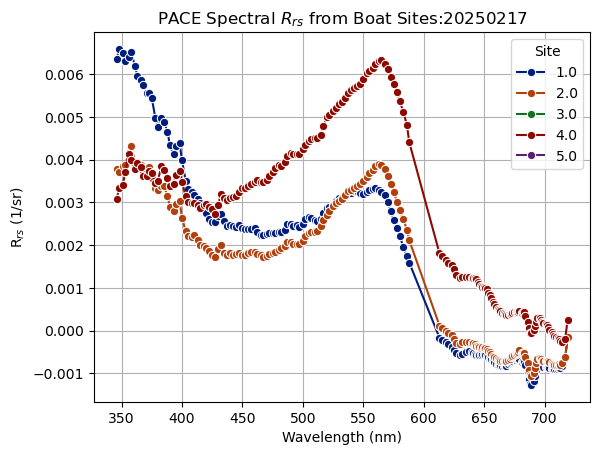

In [93]:
# Check column names to identify wavelength and Rrs values
wavelength_col = "wl" if "wl" in spectra_df.columns else spectra_df.columns[1]  # Adjust if needed
rrs_col = "Rrs" if "Rrs" in spectra_df.columns else spectra_df.columns[-2]  # Adjust if needed

fig,ax = plt.subplots(1,1)
sns.lineplot(data=spectra_df, x=wavelength_col, y=rrs_col, hue="Cast", marker="o", ax=ax, palette='dark')
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"R$_{rs}$ (1/sr)")
plt.title("PACE Spectral $R_{rs}$ from Boat Sites:" + date)
plt.legend(title="Site")
plt.grid(True)
fig.savefig('figures/' + filename + '_SiteRrs_.png', dpi=600)